# Analisis de experimentos de Escalabilidad y Latencia

A continuacion se realizara el analisis de resultados para el experimento de latencia. El objetivo es validar si la tactica de arquitectura que se aplico para la solucion del ASR se rechaza o se cumple. El ASR que se tiene es:

- Una vez que se ejecute el emparejamiento, la confirmación debe ser enviada para ambas partes en menos de 200 milisegundos. Garantizar esta latencia en un escenario de 1000 mensajes por minuto

Para lograr lo anterior se asume que la arquitectura planteada es microservicios para el componente de notificación. Para lo anterior se hace un mockup del endpoint que procesa dicho microservicio. El endpoint se muestra a continuacion

```python
# Configuración de la cola SQS
sqs = boto3.client('sqs', region_name='us-east-1')
QUEUE_URL = "https://sqs.us-east-1.amazonaws.com/538430999815/reto1-arquitectura.fifo"

def enviar_mensajes_sqs(num_mensajes):
    for _ in range(num_mensajes):
        mensaje_id = str(uuid.uuid4())
        sqs.send_message(
            QueueUrl=QUEUE_URL, 
            MessageBody=mensaje_id,
            MessageGroupId="default"  # Necesario para colas FIFO
        )
    print(f"Se enviaron {num_mensajes} mensajes a la cola SQS.")


# Función que procesa un mensaje
def procesar_mensaje(mensaje):
    try:
        inicio = start_time
        print(f"[{datetime.now().strftime('%H:%M:%S.%f')[:-3]}] Hilo {threading.current_thread().name} procesando {mensaje}")
        processing_time = np.random.uniform(0.05, 0.1)  # Simula 50-100 ms de procesamiento
        time.sleep(processing_time)  # Simula latencia del procesamiento
        fin = time.time()
        latencia = (fin - inicio) * 1000  # Convertir a ms
        print(f"[{datetime.now().strftime('%H:%M:%S.%f')[:-3]}] {mensaje} procesado en {latencia:.2f} ms")
        return latencia
    except Exception as e:
        print(f"⚠️ Error en hilo {threading.current_thread().name}: {e}")
        return None

# Función para procesar mensajes con múltiples hilos
def procesar_con_hilos(num_hilos, num_mensajes):
    mensajes = [str(uuid.uuid4()) for _ in range(num_mensajes)]
    hilos = []
    latencias = []

    for mensaje in mensajes:
        if num_hilos > 1:
            hilo = threading.Thread(target=lambda: latencias.append(procesar_mensaje(mensaje)))
            hilo.start()
            hilos.append(hilo)
        else:
            latencias.append(procesar_mensaje(mensaje))

    for hilo in hilos:
        hilo.join()

    return latencias


```


Notese que se esta simulando un endpoint en donde se cuenta con un proceso el cual, llena la cola sqs, y simula el procesamiento de cada mensaje (entre 50 y 100 ms)


## Arquitectura planteada

Para la solucion de dicho ASR se aplica la tactica de arquitectura la cual consiste en una cola SQS FIFO y concurrencia en los servicios de notificación. La hipotesis que se tiene es:

- Se requiere una concurrencia de 10 tareas (componentes de notificación) para soportar 1,000 mensajes en 60 segundos sin degradar la latencia (para nuestro escenario, que responde en menos de 200 ms)

### Experimentos
Para validar La hipotesis planteada 1,0000 peticiones para 10 servicios concurrentes de notificación (hilos), se realizan 4 experimentos:


- Experimento 1: Se lanzan 1000 mensajes a la cola SQS y se procesan de manera secuencial (1 hilo).
- Experimento 2: Se lanzan 1000 mensajes a la cola SQS y se procesan con 5 hilos.
- Experimento 3: Se lanzan 1000 mensajes a la cola SQS y se procesan con 10 hilos.
- Experimento 4: Se lanzan 1000 mensajes a la cola SQS y se procesan con 12 hilos.

Nota: cada uno de los experimentos se ejecutó un total de 50 veces. 


### Analisis de resultados

In [1]:
!pip install pandas
!pip install matplotlib
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 4.2 MB/s eta 0:00:00 0:00:010m

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [15]:
import pandas as pd
df_results = pd.read_csv('../src/test/latencias_sqs_50iter.csv')

In [16]:
df_results.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   iteracion  200000 non-null  int64  
 1   num_hilos  200000 non-null  int64  
 2   latencia   200000 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 4.6 MB


In [17]:

# separamos resultados de cada experimento
df_results_exp1 = df_results[df_results['num_hilos']==1]
df_results_exp2 = df_results[df_results['num_hilos']==5]
df_results_exp3 = df_results[df_results['num_hilos']==10]
df_results_exp4 = df_results[df_results['num_hilos']==12]


In [18]:
df_results_exp1.describe()

,iteracion,num_hilos,latencia
count,50000.000000,50000.0,50000.000000
mean,25.500000,1.0,3910.898518
std,14.431014,0.0,2255.513194
min,1.000000,1.0,8.482456
25%,13.000000,1.0,1957.807302
50%,25.500000,1.0,3911.519170
75%,38.000000,1.0,5862.830639
max,50.000000,1.0,7949.671984


In [19]:
df_results_exp2.describe()

,iteracion,num_hilos,latencia
count,50000.000000,50000.0,50000.000000
mean,25.500000,5.0,136.531314
std,14.431014,0.0,71.897249
min,1.000000,5.0,6.739855
25%,13.000000,5.0,70.867717
50%,25.500000,5.0,148.675084
75%,38.000000,5.0,196.827531
max,50.000000,5.0,294.145584


In [21]:
df_results_exp3.describe()

,iteracion,num_hilos,latencia
count,50000.000000,50000.0,50000.000000
mean,25.500000,10.0,133.849606
std,14.431014,0.0,73.474180
min,1.000000,10.0,4.535437
25%,13.000000,10.0,67.117751
50%,25.500000,10.0,144.539475
75%,38.000000,10.0,193.168402
max,50.000000,10.0,320.269346


In [22]:
from sklearn.preprocessing import MinMaxScaler

df_results_exp4.describe()


,iteracion,num_hilos,latencia
count,50000.000000,50000.0,50000.000000
mean,25.500000,12.0,82.251057
std,14.431014,0.0,51.167170
min,1.000000,12.0,0.000000
25%,13.000000,12.0,37.177553
50%,25.500000,12.0,79.350503
75%,38.000000,12.0,129.532625
max,50.000000,12.0,198.000000


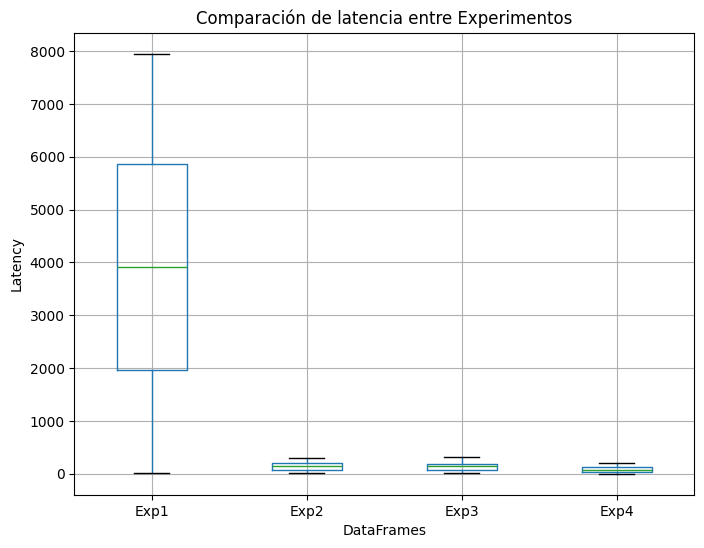

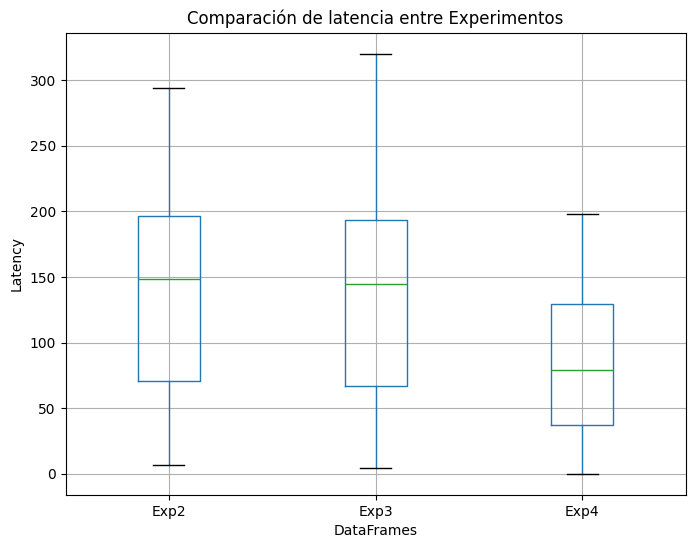

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Crear un DataFrame combinado para facilitar la visualización
data = {
    "Exp1": df_results_exp1["latencia"],
    "Exp2": df_results_exp2["latencia"],
    "Exp3": df_results_exp3["latencia"],
    "Exp4": df_results_exp4["latencia"],

}

df_combined = pd.DataFrame(data)

# Crear el boxplot
plt.figure(figsize=(8, 6))
df_combined.boxplot()
plt.title("Comparación de latencia entre Experimentos")
plt.ylabel("Latency")
plt.xlabel("DataFrames")
plt.grid(True)

# Mostrar el gráfico
plt.show()


# Crear un DataFrame combinado para facilitar la visualización
data = {
    "Exp2": df_results_exp2["latencia"],
    "Exp3": df_results_exp3["latencia"],
    "Exp4": df_results_exp4["latencia"],

}

df_combined = pd.DataFrame(data)

# Crear el boxplot
plt.figure(figsize=(8, 6))
df_combined.boxplot()
plt.title("Comparación de latencia entre Experimentos")
plt.ylabel("Latency")
plt.xlabel("DataFrames")
plt.grid(True)

# Mostrar el gráfico
plt.show()
